# Notebook 05 - Modelling & Evaluation

## Objectives

* Fit and evaluate a model for predicting the sale price of a house

## Inputs

* CSV file generated in Notebook 01: outputs/datasets/collection/house_price_records.csv
* Instructions on which variables to use for data cleaning and feature engineering. These are found in their respective notebooks.

## Outputs

The following outputs will be generated in the next notebook, but follow on from the work undertaken in this notebook:
* Train set (features and target)
* Test set (features and target)
* ML Pipeline to predict the sale price for a given property
* Feature importance plot

## Additional Comments / Conclusions

* After investigating various algorithms and combinations of hyperparameters, we find that using the RandomForestRegressor algorithm with 10-fold cross-validation has produced the best results. Investigating other high-performing algorithms has not been able to improve the model's performance on unseen data.
[* next, we investigated whether Principal Component Analysis is able to produce better results...]

---

# Import Packages

In [81]:
import joblib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA

# Data Cleaning & Feature Engineering
from feature_engine import transformation as vt
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import DropFeatures, SmartCorrelatedSelection
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms & hyperparameter optimisation
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

---

# Change working directory

* This notebook is stored in the `jupyter_notebooks` subfolder
* The current working directory therefore needs to be changed to the workspace, i.e., the working directory needs to be changed from the current folder to its parent folder

Firstly, the current directory is accessed with os.getcwd()

In [46]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\housing-price-predictor'

Next, the working directory is set as the parent of the current `jupyter_notebooks` directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* This allows access to all the files and folders within the workspace, rather than solely those within the `jupyter_notebooks` directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Finally, confirm that the new current directory has been successfully set

In [4]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\housing-price-predictor'

---

# Load Data

In [47]:
df = pd.read_csv("outputs/datasets/collection/house_price_records.csv")
print(df.shape)
df.head()

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# Pipeline, Custom Class and Data Preparation

In this section of the notebook we undertake the following tasks:
* Create the ML pipeline for regression
* State the Custom Class for Hyperparameter Optimisation
* Split the Train and Test Sets

## Create ML Pipeline

* We combine the data cleaning and feature engineering pipelines that were created in their respective notebooks.
* We then add feature selection, feature scaling and modelling.

In [48]:
# Pipeline optimisation
def PipelineOptimisation(model):
  pipeline_base = Pipeline([
    # Data Cleaning (copied from Data Cleaning notebook)
     ('median', MeanMedianImputer(imputation_method='median',
                                 variables=['2ndFlrSF', 'BedroomAbvGr',
                                 'LotFrontage', 'MasVnrArea']) ),
    ('categorical_missing', CategoricalImputer(imputation_method='missing',
                                     fill_value='Missing',
                                     variables=['BsmtFinType1']) ),
    ('garage_absent', ArbitraryNumberImputer(arbitrary_number=0,
                                               variables=['GarageYrBlt'])),
    ('categorical_frequent', CategoricalImputer(imputation_method='frequent',
                                     variables=['GarageFinish']) ),
    ('drop',  DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF']) ),

    # Feature Engineering (copied from Feature Engineering notebook)
    ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                 variables=['BsmtExposure',
                                                            'BsmtFinType1',
                                                            'GarageFinish',
                                                            'KitchenQual'] ) ),
    
    ('log_transform', vt.LogTransformer(variables=['1stFlrSF',
                                                   'GrLivArea',
                                                   'LotArea',
                                                   'LotFrontage'])),
    
    ('yeo_johnson_transform', vt.YeoJohnsonTransformer(variables=['BsmtUnfSF',
                                                                  'GarageArea',
                                                                  'OpenPorchSF'])),
    
    ('power_transform', vt.PowerTransformer(variables=['TotalBsmtSF',
                                                       'MasVnrArea'])),    
       
    ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables= None,
     method="spearman", threshold=0.6,selection_method="variance") ),

    ("feat_scaling", StandardScaler() ),

    ("feat_selection",  SelectFromModel(model) ),

    ("model", model ),
    ])

  return pipeline_base

## Custom Class for Hyperparameter Optimisation

Custom Class for Hyperparameter Optimisation, copied and adapted from Code Institute's Walkthrough Project 2 on customer churn:

In [49]:
class HyperparameterOptimisationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimisation(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train and Test Sets

In [50]:
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1) ,
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


---

# Hyperparameter Optimisation

## Grid Search CV - sklearn

Use default hyperparameters to find the most suitable algorithm


In [51]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using the default parameters

In [52]:
search = HyperparameterOptimisationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar

Check the results

In [53]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.674306,0.769451,0.805133,0.048638
3,ExtraTreesRegressor,0.654218,0.756489,0.810022,0.053468
5,GradientBoostingRegressor,0.518486,0.748213,0.838638,0.116989
6,XGBRegressor,0.602233,0.689534,0.755556,0.068149
0,LinearRegression,0.633406,0.682125,0.709829,0.026843
4,AdaBoostRegressor,0.579679,0.673547,0.733374,0.057077
1,DecisionTreeRegressor,0.429289,0.566947,0.690236,0.099146


Note the best model

In [54]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'RandomForestRegressor'

We see that the best-performing model is `RandomForestRegressor`, with a mean R2 score around 0.77. `ExtraTreesRegressor` and `GradientBoostingRegressor` also have relatively strong performances and may be worth further investigation, particularly if hyperparameter optimisation fails to yield further improvement with `RandomForestRegressor`.
* An R2 score of at least 0.75 on both train and test sets has been agreed with the client.
* We will aim to achieve as high a score as possible by adjusting the hyperparameters.

We now perform an extensive search on the most suitable algorithm `RandomForestRegressor` to find the best hyperparameter configuration. A wide range of hyperparameter values has been tested, with the final search that appears below having yielded the most optimal results.

* n_estimators represents the number of decision trees in the forest.
    - Values of 50, 100, 140, 200 and 400 were considered.
* max_depth is the number of splits allowed by each tree in the forest. Typically, allowing larger numbers of splits in each tree enables the trees to explain more variation in the data; however, trees with many splits may overfit the data.
    - In this case, rather than mitigating overfitting, reducing max_depth led to a poor performance on both train and test sets.
* min_samples_split is the minimum number of samples required to split each node.
    - Restricting to allow only larger values caused poor performance on both train and test sets, so the default value of 2 has been chosen.
* min_samples_leaf is the minimum number of samples required to split each leaf.
    - Restricting to allow only larger values caused poor performance on both train and test sets, so the default value of 1 has been chosen.
* max_leaf_nodes defines the maximum number of leaf nodes allowed in a tree within the forest. It provides a constraint on the growth of individual decision trees.
    - Restricting this value limits the complexity of the tree, which can help control overfitting, although here it has failed to do so.
* max_features determines the number of features to resample before determining the best split. Larger values can result in improved performance by allowing a larger selection of features from which to choose the best split, but can also cause overfitting.
    - Reducing the value further from sqrt or log2 has not improved overfitting and has led to a decrease in performance.
* min_impurity_decrease represents the minimum reduction in impurity required for a split to be deemed worthwhile.
    - Increasing this value can help to avoid overfitting; however, here further increases beyond the value of 0.05 selected below have made no difference.

In [55]:
models_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params_search = {
    "RandomForestRegressor": {
        'model__n_estimators': [50, 100, 140],
        'model__max_depth': [None, 4, 15],
        'model__min_samples_split': [2, 15, 50],
        'model__min_samples_leaf': [1, 20, 50],
        'model__max_leaf_nodes': [None, 50, 100],
        'model__max_features': [None, 'sqrt', 'log2'],
        'model__min_impurity_decrease': [0.0, 0.05, 0.1]
    }
}

Extensive GridSearch CV

In [56]:
search = HyperparameterOptimisationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar

Check the results

In [57]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__max_leaf_nodes,model__min_impurity_decrease,model__min_samples_leaf,model__min_samples_split,model__n_estimators
272,RandomForestRegressor,0.714348,0.783267,0.822892,0.037807,None,sqrt,None,0.05,1,2,140
515,RandomForestRegressor,0.714348,0.783267,0.822892,0.037807,None,log2,None,0.05,1,2,140
299,RandomForestRegressor,0.714348,0.783267,0.822892,0.037807,None,sqrt,None,0.1,1,2,140
542,RandomForestRegressor,0.714348,0.783267,0.822892,0.037807,None,log2,None,0.1,1,2,140
488,RandomForestRegressor,0.715331,0.782998,0.820971,0.037077,None,log2,None,0.0,1,2,140
...,...,...,...,...,...,...,...,...,...,...,...,...
1128,RandomForestRegressor,0.549467,0.632189,0.706069,0.057281,4,sqrt,50,0.1,50,15,50
1125,RandomForestRegressor,0.549467,0.632189,0.706069,0.057281,4,sqrt,50,0.1,50,2,50
1395,RandomForestRegressor,0.549467,0.632189,0.706069,0.057281,4,log2,100,0.0,50,2,50
1314,RandomForestRegressor,0.549467,0.632189,0.706069,0.057281,4,log2,50,0.0,50,2,50


Check the best model

In [58]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'RandomForestRegressor'

Parameters for best model

In [59]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': None,
 'model__max_features': 'sqrt',
 'model__max_leaf_nodes': None,
 'model__min_impurity_decrease': 0.05,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

Define the best regressor, based on search

In [60]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'LotFrontage', 'MasVnrArea'])),
                ('categorical_missing',
                 CategoricalImputer(variables=['BsmtFinType1'])),
                ('garage_absent',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['GarageYrBlt'])),
                ('categorical_frequent',
                 CategoricalImputer(imputation_method='frequent',
                                    variables...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                                              

---

# Assess Feature Importance

* These are the 4 most important features in descending order. The model was trained on them: 
['TotalBsmtSF', 'YearBuilt', '2ndFlrSF', 'LotArea']


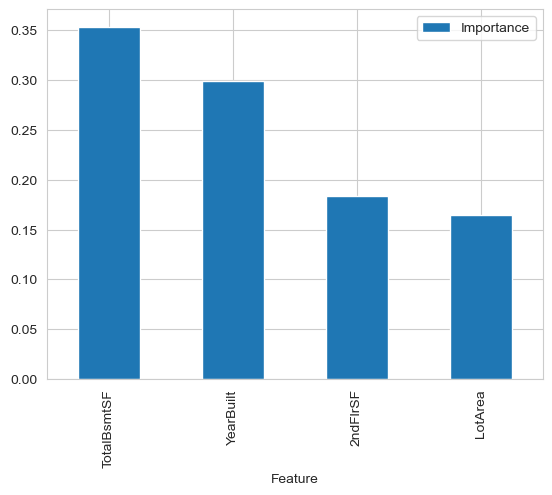

In [61]:
# there are ten pipeline steps in total that involve data cleaning and feature engineering
data_cleaning_feat_eng_steps = 10
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

---

# Evaluate Regressor on Train and Test Sets

In [62]:
def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Model Evaluation 

* Train Set
R2 Score: 0.969
Mean Absolute Error: 8844.825
Mean Squared Error: 190512549.905
Root Mean Squared Error: 13802.628


* Test Set
R2 Score: 0.774
Mean Absolute Error: 25560.783
Mean Squared Error: 1560432824.16
Root Mean Squared Error: 39502.314




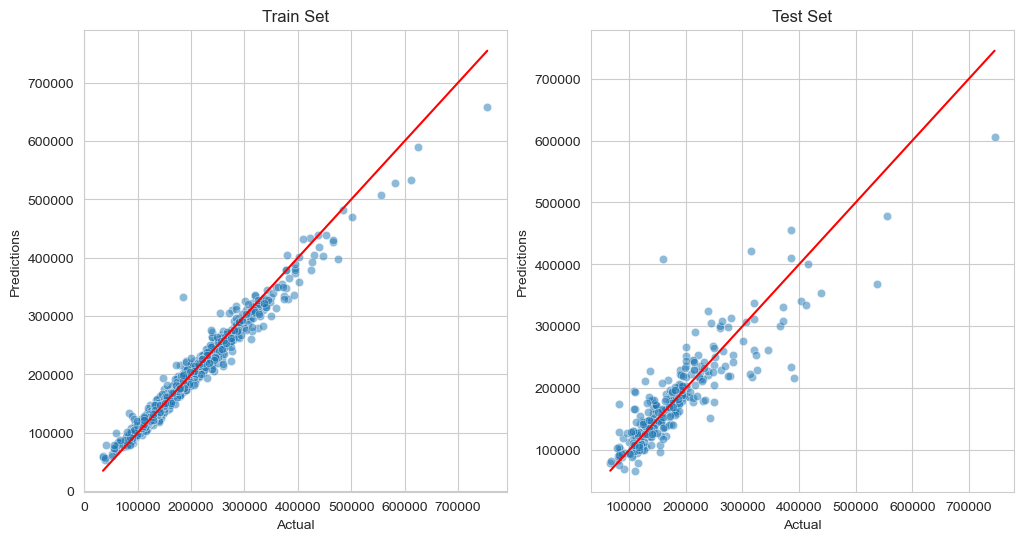

In [63]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

We note here that the model does meet our criteria, which require an R2 score of at least 0.75 on both train and test sets.
* However, despite extensive testing with different hyperparameter values, the model does still appear to be overfitting to the training data, with a much higher R2 score of 0.969 on the train set, vs 0.774 on the test set.
* We can therefore explore some additional methods to reduce overfitting. Although the model does meet the criteria, we would prefer to have a model that is better able to generalise to unseen data.

---

# Rerun with higher CV score to try and reduce overfitting

Extensive GridSearch CV

In [64]:
search = HyperparameterOptimisationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=10)


Running GridSearchCV for RandomForestRegressor 

Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar

Check the results

In [65]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__max_leaf_nodes,model__min_impurity_decrease,model__min_samples_leaf,model__min_samples_split,model__n_estimators
1946,RandomForestRegressor,0.646979,0.784205,0.847945,0.054554,15,log2,None,0.0,1,2,140
1703,RandomForestRegressor,0.646979,0.784205,0.847945,0.054554,15,sqrt,None,0.0,1,2,140
542,RandomForestRegressor,0.64115,0.783827,0.842501,0.054533,None,log2,None,0.1,1,2,140
272,RandomForestRegressor,0.64115,0.783827,0.842501,0.054533,None,sqrt,None,0.05,1,2,140
299,RandomForestRegressor,0.64115,0.783827,0.842501,0.054533,None,sqrt,None,0.1,1,2,140
...,...,...,...,...,...,...,...,...,...,...,...,...
1449,RandomForestRegressor,0.499854,0.648901,0.73657,0.070162,4,log2,100,0.1,50,2,50
1452,RandomForestRegressor,0.499854,0.648901,0.73657,0.070162,4,log2,100,0.1,50,15,50
1395,RandomForestRegressor,0.499854,0.648901,0.73657,0.070162,4,log2,100,0.0,50,2,50
1125,RandomForestRegressor,0.499854,0.648901,0.73657,0.070162,4,sqrt,50,0.1,50,2,50


Check the best model

In [66]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'RandomForestRegressor'

Parameters for best model

In [67]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 15,
 'model__max_features': 'sqrt',
 'model__max_leaf_nodes': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

Define the best regressor, based on search

In [68]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'LotFrontage', 'MasVnrArea'])),
                ('categorical_missing',
                 CategoricalImputer(variables=['BsmtFinType1'])),
                ('garage_absent',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['GarageYrBlt'])),
                ('categorical_frequent',
                 CategoricalImputer(imputation_method='frequent',
                                    variables...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                                              

We see that a slightly different set of hyperparameters have been selected for the pipeline using 10 folds instead of 5.

---

# Assess feature importance with new hyperparameters

* These are the 4 most important features in descending order. The model was trained on them: 
['TotalBsmtSF', 'YearBuilt', '2ndFlrSF', 'LotArea']


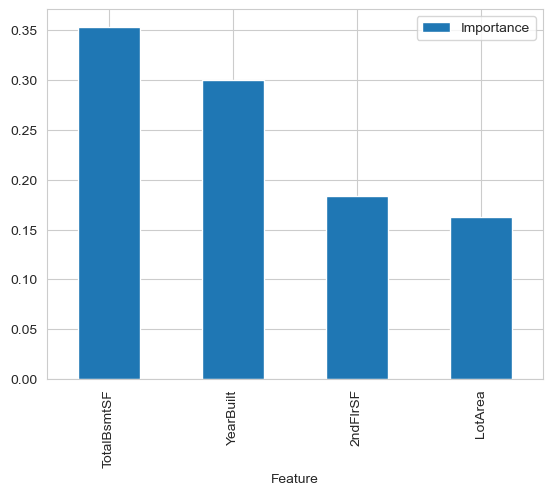

In [69]:
# there are ten pipeline steps in total that involve data cleaning and feature engineering
data_cleaning_feat_eng_steps = 10
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

---

# Reevaluate on Train and Test Sets

Model Evaluation 

* Train Set
R2 Score: 0.967
Mean Absolute Error: 9415.438
Mean Squared Error: 202231884.776
Root Mean Squared Error: 14220.826


* Test Set
R2 Score: 0.775
Mean Absolute Error: 25674.948
Mean Squared Error: 1556222980.621
Root Mean Squared Error: 39448.992




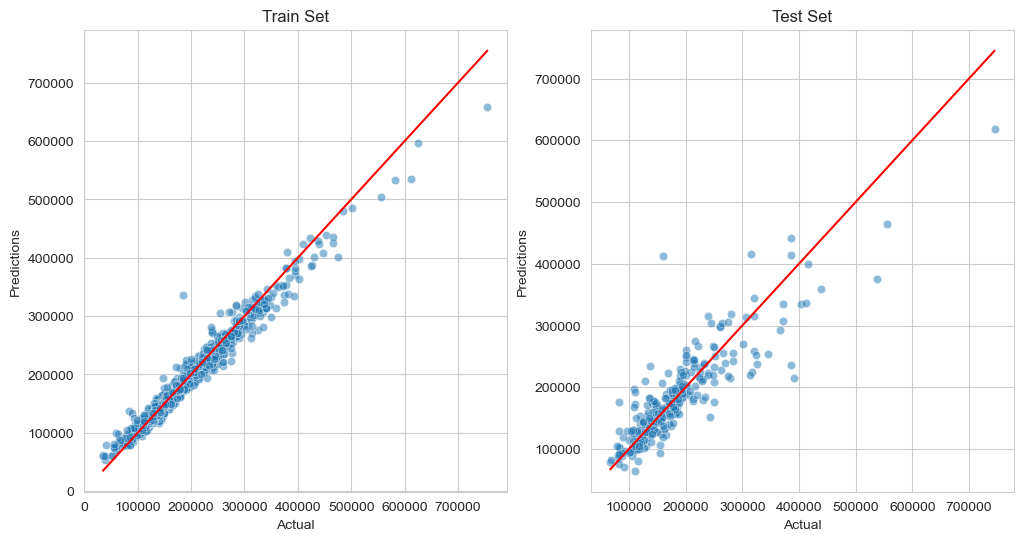

In [70]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

We see a very marginal improvement to the overfitting issue here.
* It would in theory be possible to try increasing the number of folds further.
* However, this will increase the computational cost of cross-validation and has a high chance of having diminishing returns. Given that the improvement seen when increasing the number of folds from 5 to 10 is too small to be significant, it is not likely to be worth adjusting this further.

---

# Investigate results using ExtraTreesRegressor and GradientBoostingRegressor

ExtraTreesRegressor was the second-best performing algorithm in the quick search. GradientBoostingRegressor did not perform quite as well but is known for handling overfitting well.

In [71]:
models_extra_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_extra_search = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 25, 50],
        'model__min_samples_leaf': [1, 20, 50],
        'model__min_impurity_decrease': [0.0, 0.05, 0.1],
        'model__min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    },
    "GradientBoostingRegressor": {
        'model__n_estimators': [100,50,140],
        'model__learning_rate':[0.1, 0.01, 0.001],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 25, 50],
        'model__min_samples_leaf': [1, 20, 50],
        'model__max_leaf_nodes': [None, 25, 50],
},
}

Extensive GridSearch CV

In [72]:
extra_search = HyperparameterOptimisationSearch(models=models_extra_search, params=params_extra_search)
extra_search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar

Check the results

In [73]:
extra_grid_search_summary, extra_grid_search_pipelines = extra_search.score_summary(sort_by='mean_score')
extra_grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_impurity_decrease,model__min_samples_leaf,model__min_samples_split,model__min_weight_fraction_leaf,model__n_estimators,model__learning_rate,model__max_leaf_nodes
742,GradientBoostingRegressor,0.706614,0.777277,0.828472,0.049882,None,NaN,20,25,NaN,50,0.1,None
739,GradientBoostingRegressor,0.706614,0.777277,0.828472,0.049882,None,NaN,20,2,NaN,50,0.1,None
796,GradientBoostingRegressor,0.706614,0.777277,0.828472,0.049882,None,NaN,20,25,NaN,50,0.1,50
793,GradientBoostingRegressor,0.706614,0.777277,0.828472,0.049882,None,NaN,20,2,NaN,50,0.1,50
904,GradientBoostingRegressor,0.705511,0.776405,0.826624,0.04942,15,NaN,20,25,NaN,50,0.1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,GradientBoostingRegressor,0.026956,0.047819,0.055437,0.010748,3,NaN,50,25,NaN,50,0.001,None
1315,GradientBoostingRegressor,0.026956,0.047819,0.055437,0.010748,3,NaN,50,2,NaN,50,0.001,None
1303,GradientBoostingRegressor,0.023957,0.047376,0.055872,0.012,3,NaN,1,50,NaN,50,0.001,None
1330,GradientBoostingRegressor,0.023957,0.047373,0.055872,0.011998,3,NaN,1,50,NaN,50,0.001,25


Check the best model

In [74]:
extra_best_model = extra_grid_search_summary.iloc[0, 0]
extra_best_model

'GradientBoostingRegressor'

Parameters for best model

In [75]:
extra_grid_search_pipelines[extra_best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 20,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

Define the best regressor, based on search

In [76]:
extra_best_regressor_pipeline = extra_grid_search_pipelines[extra_best_model].best_estimator_
extra_best_regressor_pipeline

Pipeline(steps=[('median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'LotFrontage', 'MasVnrArea'])),
                ('categorical_missing',
                 CategoricalImputer(variables=['BsmtFinType1'])),
                ('garage_absent',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['GarageYrBlt'])),
                ('categorical_frequent',
                 CategoricalImputer(imputation_method='frequent',
                                    variables...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                                              

## Assess feature importance for model using GradientBoostingRegressor

* These are the 5 most important features in descending order. The model was trained on them: 
['YearBuilt', 'TotalBsmtSF', '2ndFlrSF', 'LotArea', 'KitchenQual']


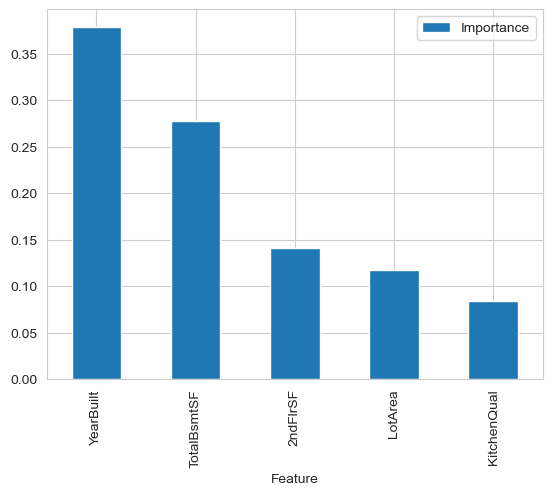

In [77]:
# there are ten pipeline steps in total that involve data cleaning and feature engineering
data_cleaning_feat_eng_steps = 10
extra_columns_after_data_cleaning_feat_eng = (Pipeline(extra_best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

extra_best_features = extra_columns_after_data_cleaning_feat_eng[extra_best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
extra_df_feature_importance = (pd.DataFrame(data={
    'Feature': extra_columns_after_data_cleaning_feat_eng[extra_best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': extra_best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# most important features statement and plot
print(f"* These are the {len(extra_best_features)} most important features in descending order. "
      f"The model was trained on them: \n{extra_df_feature_importance['Feature'].to_list()}")

extra_df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

Evaluate model using GradientBoostingRegressor on Train and Test Sets

Model Evaluation 

* Train Set
R2 Score: 0.893
Mean Absolute Error: 14685.979
Mean Squared Error: 657062426.469
Root Mean Squared Error: 25633.229


* Test Set
R2 Score: 0.753
Mean Absolute Error: 24473.217
Mean Squared Error: 1707382845.528
Root Mean Squared Error: 41320.489




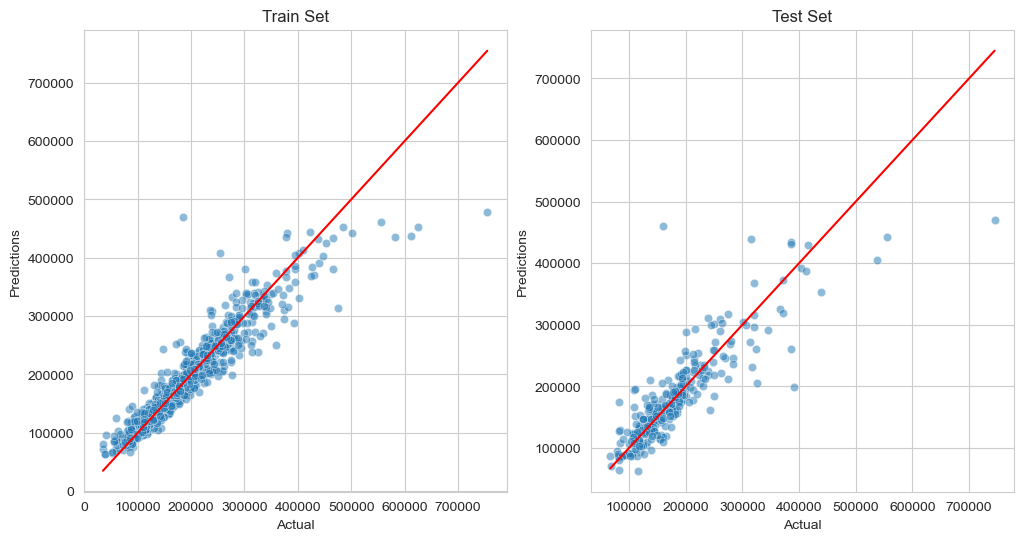

In [78]:
regression_performance(X_train, y_train, X_test, y_test, extra_best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, extra_best_regressor_pipeline)

We see that although the difference in performance between the train and test sets is indeed reduced with GradientBoostingRegressor, the overall performance of the model is also unfortunately worse than with RandomForestRegressor.
* We will therefore select the RandomForestRegressor model with 10-fold cross-validation.
* Next, we will investigate whether Principal Component Analysis can be used to produce a more accurate model to improve the results further.

---

# Regressor pipeline with PCA

We can also investigate whether PCA might produce a better model. We want to explore potential values for the number of components that we use.
* Firstly, we prepare the data by applying the data cleaning, feature engineering and feature scaling steps.
    - The feature selection step is not needed because the PCA itself transforms the original features into a new set of variables, or principal components.
    - This happens sequentially: the first principal component describes as much variation as possible; the second describes as much of the left-over variation as possible (with the constraint that it must be uncorrelated with the first principal component); and so on.
    - At maximum, there can be as many principal components as there are original variables (i.e., the maximum possible number here would be 17). However, we can choose to use fewer of them if we see a large percentage of variation captured in some smaller set. 
    - Note that these principal components do not map directly to the original features, and extracting a real-world interpretation of them is challenging.

In [80]:
pipeline = PipelineOptimisation(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:11]) # the first 11 steps relate to data cleaning, feature engineering and feature scaling
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar

The data is now prepared and scaled, and we are ready to apply PCA to it. The following code is copied and adapted from CI's WP02:

* The 17 components explain 100.0% of the data 



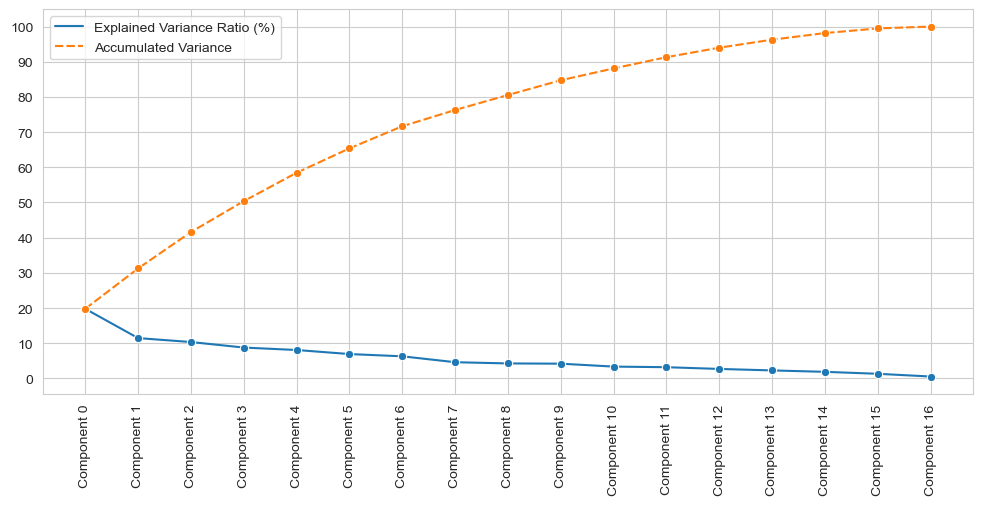

In [82]:
n_components = 17

def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

Selecting a number for n_components here is tricky; ideally we would like to see a small number of components represent a large proportion of the data.
* Here we see that the first 8 components explain over 75% of the data, so we can try selecting 8 components:

* The 8 components explain 76.28% of the data 



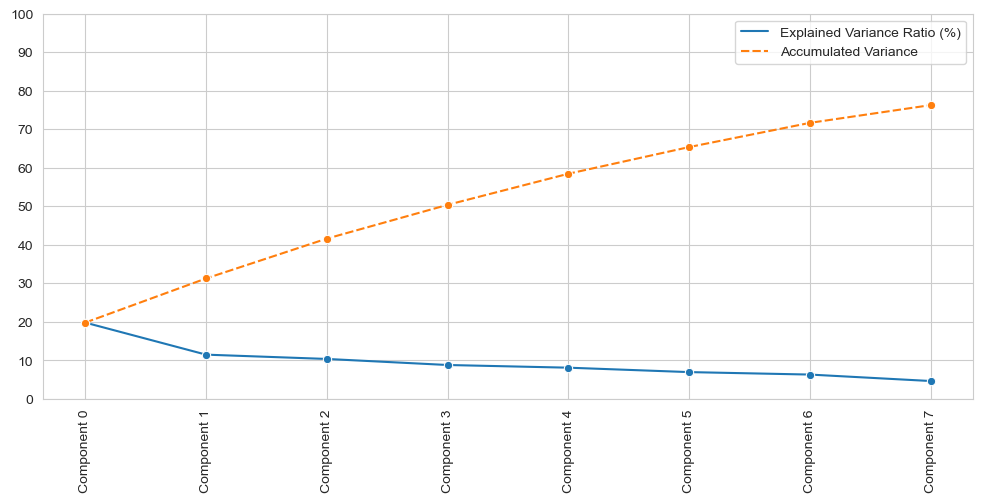

In [84]:
n_components = 8
pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [106]:
def pca_pipeline_optimisation(model):
    pipeline_base = Pipeline([
        # Data Cleaning (copied from Data Cleaning notebook)
        ('median', MeanMedianImputer(imputation_method='median',
                                    variables=['2ndFlrSF', 'BedroomAbvGr',
                                    'LotFrontage', 'MasVnrArea']) ),
        ('categorical_missing', CategoricalImputer(imputation_method='missing',
                                        fill_value='Missing',
                                        variables=['BsmtFinType1']) ),
        ('garage_absent', ArbitraryNumberImputer(arbitrary_number=0,
                                                variables=['GarageYrBlt'])),
        ('categorical_frequent', CategoricalImputer(imputation_method='frequent',
                                        variables=['GarageFinish']) ),
        ('drop',  DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF']) ),

        # Feature Engineering (copied from Feature Engineering notebook)
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                    variables=['BsmtExposure',
                                                                'BsmtFinType1',
                                                                'GarageFinish',
                                                                'KitchenQual'] ) ),
        
        ('log_transform', vt.LogTransformer(variables=['1stFlrSF',
                                                    'GrLivArea',
                                                    'LotArea',
                                                    'LotFrontage'])),
        
        ('yeo_johnson_transform', vt.YeoJohnsonTransformer(variables=['BsmtUnfSF',
                                                                    'GarageArea',
                                                                    'OpenPorchSF'])),
        
        ('power_transform', vt.PowerTransformer(variables=['TotalBsmtSF',
                                                        'MasVnrArea'])),    
        
        ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables= None,
        method="spearman", threshold=0.6,selection_method="variance") ),

        ("feat_scaling", StandardScaler() ),

        # PCA replaces feature felection
        ("PCA", PCA(n_components=8, random_state=0)),

        ("model", model ),
    ])

    return pipeline_base

## Custom Class for Hyperparameter Optimisation - adjusted to use PCA pipeline:

In [107]:
class PCAHyperparameterOptimisationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = pca_pipeline_optimisation(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Grid Search CV – Sklearn

In [108]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


### Use standard hyperparameters to find the most suitable model

In [109]:
models_quick_search_pca = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search_pca = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do an optimisation search

In [110]:
pca_quick_search = PCAHyperparameterOptimisationSearch(models=models_quick_search_pca, params=params_quick_search_pca)
pca_quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar

Check the results

In [111]:
pca_grid_search_summary, pca_grid_search_pipelines = pca_quick_search.score_summary(sort_by='mean_score')
pca_grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.671926,0.755345,0.799844,0.043675
3,ExtraTreesRegressor,0.642091,0.749992,0.799439,0.057403
5,GradientBoostingRegressor,0.628105,0.73458,0.781394,0.055188
6,XGBRegressor,0.588159,0.712111,0.782279,0.065259
0,LinearRegression,0.601049,0.667771,0.734632,0.043558
4,AdaBoostRegressor,0.506505,0.650614,0.712607,0.074162
1,DecisionTreeRegressor,0.402671,0.579558,0.664771,0.098173


### Do an extensive search on the most suitable model to find the best hyperparameter configuration

Define the model and parameters for the extensive search

In [112]:
pca_models_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

pca_params_search = {
    "RandomForestRegressor": {
        'model__n_estimators': [50, 100, 140],
        'model__max_depth': [None, 4, 15],
        'model__min_samples_split': [2, 15, 50],
        'model__min_samples_leaf': [1, 20, 50],
        'model__max_leaf_nodes': [None, 50, 100],
        'model__max_features': [None, 'sqrt', 'log2'],
        'model__min_impurity_decrease': [0.0, 0.05, 0.1]
    }
}

Extensive GridSearch CV

In [113]:
pca_search = PCAHyperparameterOptimisationSearch(models=pca_models_search, params=pca_params_search)
pca_search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\franc\housing-price-predictor\venv\lib\site-packages\feature_engine\selection\smar

Check the results

In [118]:
pca_grid_search_summary, pca_grid_search_pipelines = pca_search.score_summary(sort_by='mean_score')
pca_grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__max_leaf_nodes,model__min_impurity_decrease,model__min_samples_leaf,model__min_samples_split,model__n_estimators
488,RandomForestRegressor,0.712386,0.759532,0.790258,0.025891,None,log2,None,0.0,1,2,140
515,RandomForestRegressor,0.712386,0.759308,0.790194,0.025843,None,log2,None,0.05,1,2,140
542,RandomForestRegressor,0.712386,0.759308,0.790194,0.025843,None,log2,None,0.1,1,2,140
1973,RandomForestRegressor,0.709743,0.756767,0.797058,0.029122,15,log2,None,0.05,1,2,140
2000,RandomForestRegressor,0.709743,0.756767,0.797058,0.029122,15,log2,None,0.1,1,2,140
...,...,...,...,...,...,...,...,...,...,...,...,...
1017,RandomForestRegressor,0.413902,0.459143,0.503881,0.034175,4,sqrt,None,0.05,50,2,50
996,RandomForestRegressor,0.413902,0.459143,0.503881,0.034175,4,sqrt,None,0.0,50,50,50
993,RandomForestRegressor,0.413902,0.459143,0.503881,0.034175,4,sqrt,None,0.0,50,15,50
990,RandomForestRegressor,0.413902,0.459143,0.503881,0.034175,4,sqrt,None,0.0,50,2,50


Check the best model

In [119]:
pca_best_model = pca_grid_search_summary.iloc[0,0]
pca_best_model

'RandomForestRegressor'

The parameters for the best model

In [120]:
pca_grid_search_pipelines[pca_best_model].best_params_

{'model__max_depth': None,
 'model__max_features': 'log2',
 'model__max_leaf_nodes': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

Define the best regressor pipeline

In [121]:
pca_best_regressor_pipeline = pca_grid_search_pipelines[pca_best_model].best_estimator_
pca_best_regressor_pipeline

Pipeline(steps=[('median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'LotFrontage', 'MasVnrArea'])),
                ('categorical_missing',
                 CategoricalImputer(variables=['BsmtFinType1'])),
                ('garage_absent',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['GarageYrBlt'])),
                ('categorical_frequent',
                 CategoricalImputer(imputation_method='frequent',
                                    variables...
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                   

## Evaluate Regressor with PCA on Train and Test Sets

Model Evaluation 

* Train Set
R2 Score: 0.967
Mean Absolute Error: 9165.309
Mean Squared Error: 202752767.514
Root Mean Squared Error: 14239.128


* Test Set
R2 Score: 0.762
Mean Absolute Error: 23927.394
Mean Squared Error: 1642504505.105
Root Mean Squared Error: 40527.824




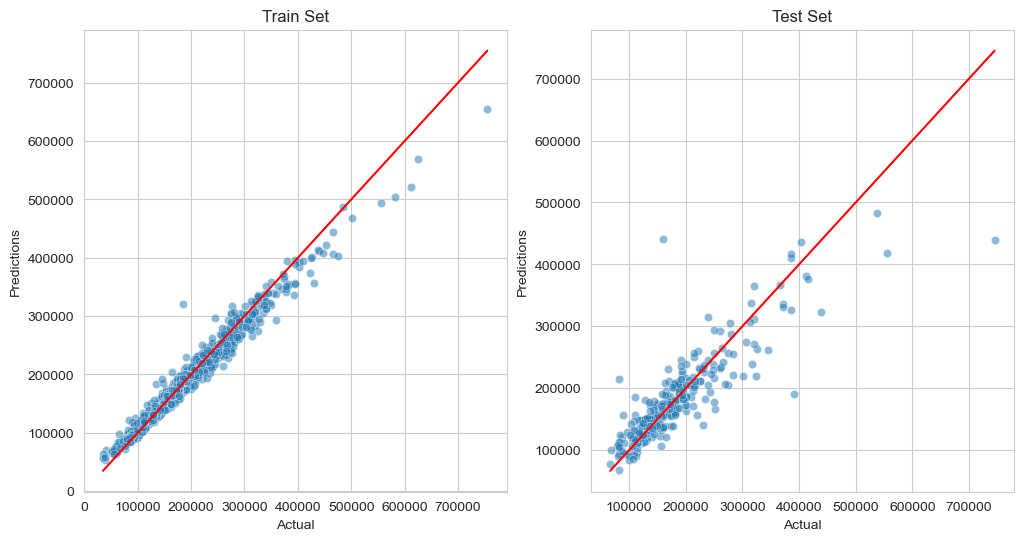

In [122]:
regression_performance(X_train, y_train, X_test, y_test,pca_best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            pca_best_regressor_pipeline)

We see that regression using PCA has also performed acceptably but has not improved performance beyond what we have achieved above. Additionally, we prefer not to use PCA unless necessary, since unlike the main regressor it does not have readily interpretable features.
* We will therefore proceed to refit the original pipeline with the best features in the following section.

---

# Refit the highest performing pipeline with the best features

We have created a number of pipelines:
* Regression using the highest-performing model in the original quick search, `RandomForestRegressor`, with 5-fold cross-validation
* Regression using the highest-performing model in the original quick search, `RandomForestRegressor`, with 10-fold cross-validation
* Regression searching on the two next-highest performing models in the original quick search, `ExtraTreesRegressor` and `GradientBoostingRegressor`, then using `GradientBoostingRegressor` to fit the pipeline, since it performed the better of these two following hyperparameter optimisation
* Regression using PCA

Of these pipelines, the one fitted with regression using the highest-performing model in the original quick search, `RandomForestRegressor`, with 10-fold cross-validation, was the most effective, and we will therefore choose this pipeline.

In [133]:
best_regressor_pipeline

Pipeline(steps=[('median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'LotFrontage', 'MasVnrArea'])),
                ('categorical_missing',
                 CategoricalImputer(variables=['BsmtFinType1'])),
                ('garage_absent',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['GarageYrBlt'])),
                ('categorical_frequent',
                 CategoricalImputer(imputation_method='frequent',
                                    variables...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                                              

## We split the Train and Test sets, with the best features only:

In [134]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


Subset the best features:

In [135]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head()

* Train set: (1168, 4) (1168,) 
* Test set: (292, 4) (292,)


,2ndFlrSF,LotArea,TotalBsmtSF,YearBuilt
618,0.0,11694,1822,2007
870,0.0,6600,894,1962
92,0.0,13360,876,1921
817,0.0,13265,1568,2002
302,0.0,13704,1541,2001


Now we rewrite the pipeline, with only the best features:

In [136]:
def PipelineOptimisation(model):
  pipeline_base = Pipeline([
    # Data Cleaning for only the best features
     ('median', MeanMedianImputer(imputation_method='median',
                                 variables=['2ndFlrSF']) ),

    # Feature Engineering for only the best features
    ('log_transform', vt.LogTransformer(variables=['LotArea'])),
       
    ('power_transform', vt.PowerTransformer(variables=['TotalBsmtSF'])),    
       
    # Smart Correlated Selection is no longer needed, since we specify the features to be included

    ("feat_scaling", StandardScaler() ),

    # Feature Selection is no longer needed, since we specify the features to be included

    ("model", model ),
    ])

  return pipeline_base

## Grid Search CV – Sklearn

We use the same model from the previous GridCV search:

In [137]:
models_search

{'RandomForestRegressor': RandomForestRegressor(random_state=0)}

And the best parameters from the previous GridCV search:

In [138]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 15,
 'model__max_features': 'sqrt',
 'model__max_leaf_nodes': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

Adjust this output manually so that the hyperparameter values appear as a list:

In [139]:
params_search = {'RandomForestRegressor': {
    'model__max_depth': [15],
    'model__max_features': ['sqrt'],
    'model__max_leaf_nodes': [None],
    'model__min_impurity_decrease': [0.0],
    'model__min_samples_leaf': [1],
    'model__min_samples_split': [2],
    'model__n_estimators': [140]
 }
 }
params_search

{'RandomForestRegressor': {'model__max_depth': [15],
  'model__max_features': ['sqrt'],
  'model__max_leaf_nodes': [None],
  'model__min_impurity_decrease': [0.0],
  'model__min_samples_leaf': [1],
  'model__min_samples_split': [2],
  'model__n_estimators': [140]}}

GridSearch CV

In [140]:
search = HyperparameterOptimisationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=10)


Running GridSearchCV for RandomForestRegressor 

Fitting 10 folds for each of 1 candidates, totalling 10 fits


Check the results:

In [141]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__max_leaf_nodes,model__min_impurity_decrease,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,RandomForestRegressor,0.640759,0.782601,0.847945,0.05579,15,sqrt,None,0.0,1,2,140


Check the best model:

In [142]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

Define the best regressor pipeline:

In [143]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('median', MeanMedianImputer(variables=['2ndFlrSF'])),
                ('log_transform', LogTransformer(variables=['LotArea'])),
                ('power_transform',
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=15, max_features='sqrt',
                                       n_estimators=140, random_state=0))])

Assess feature importance:

* These are the 4 most important features in descending order. The model was trained on them: 
['TotalBsmtSF', 'YearBuilt', '2ndFlrSF', 'LotArea']


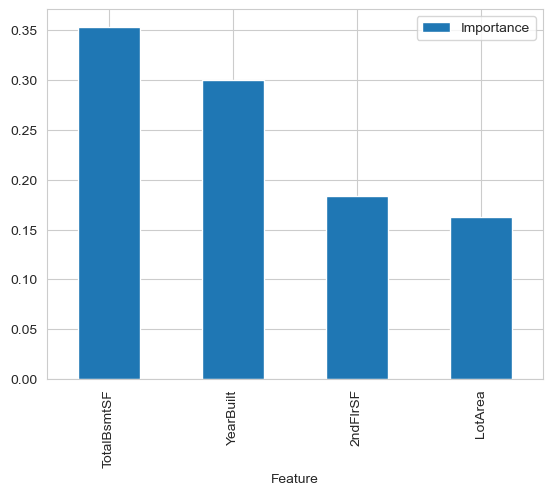

In [146]:
# there are now three pipeline steps in total that involve data cleaning and feature engineering
data_cleaning_feat_eng_steps = 3
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

Evaluate the performance of the train and test sets:

Model Evaluation 

* Train Set
R2 Score: 0.967
Mean Absolute Error: 9415.438
Mean Squared Error: 202231884.776
Root Mean Squared Error: 14220.826


* Test Set
R2 Score: 0.775
Mean Absolute Error: 25674.948
Mean Squared Error: 1556222980.621
Root Mean Squared Error: 39448.992




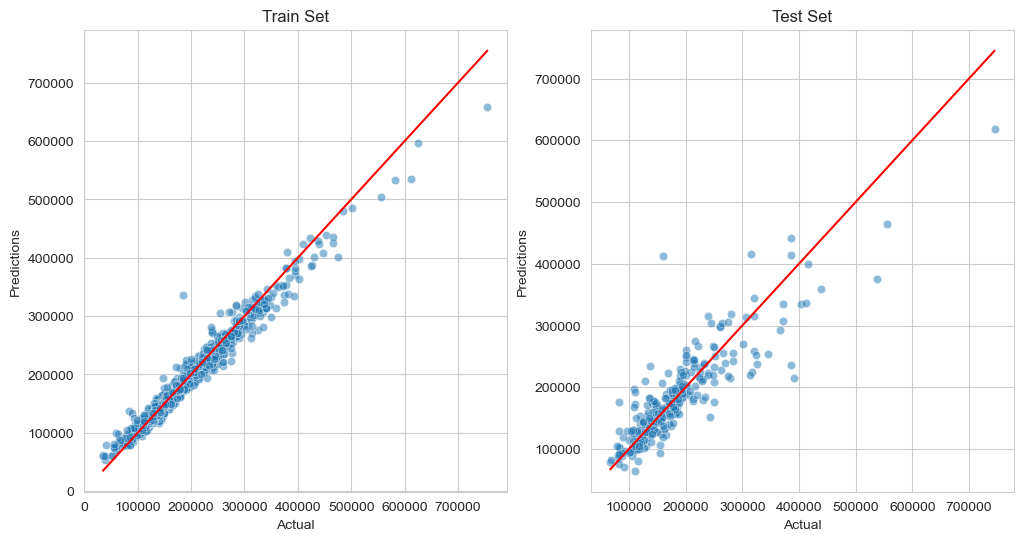

In [147]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

---

# Conclusions and Next Steps

* After investigating various algorithms and combinations of hyperparameters, we find that using the RandomForestRegressor algorithm with 10-fold cross-validation has produced the best results. Investigating other high-performing algorithms has not been able to improve the model's performance on unseen data.
* [next, we will undertake the following steps:
    - Refit the pipeline using only the most important features, verify performance with these features only, and save the datasets, modelling pipeline and feature importance plot.
    - Investigate whether Principal Component Analysis is able to produce better results.]